In [38]:
import sys

assert sys.version_info >=(3,8), "This project requires Python 3.8+"

In [39]:
from packaging import version
import torch


assert version.parse(torch.__version__) >= version.parse("2.1.2"), "This project requires pytorch 2.1.1 or above!"

In [40]:
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [42]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [43]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.random.manual_seed(42)

**DATASETS & DATALOADERS**

* Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

* PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets



In [44]:
from torch.utils.data import random_split

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=ToTensor())
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=ToTensor())

train_ds, val_ds = random_split(train_dataset, [50000, 10000])


In [45]:
print("train+val size: ", train_dataset.data.shape)
print("test size: ", test_ds.data.shape)

train+val size:  torch.Size([60000, 28, 28])
test size:  torch.Size([10000, 28, 28])


In [46]:
## Hyperparameters
input_size = [*train_dataset.data.shape[1:]]
number_epochs = 10
batch_size = 32
learning_rate = 0.01

In [47]:
train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


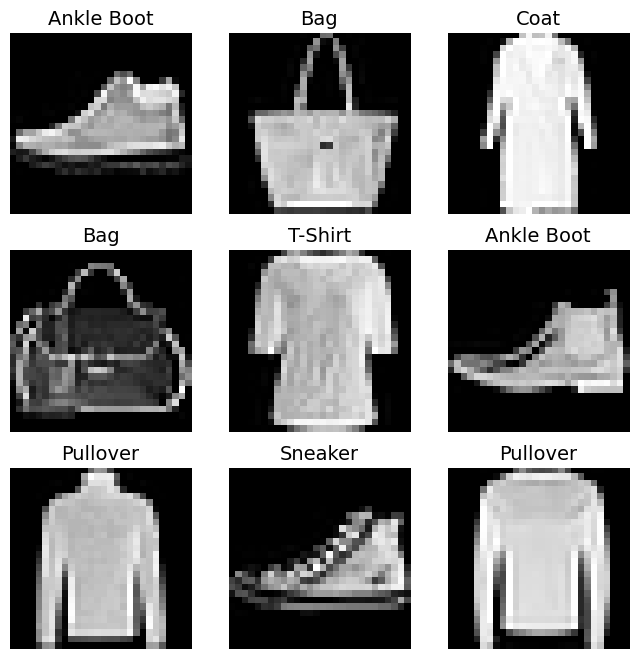

In [48]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in tqdm(range(1, cols * rows + 1)):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [49]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import shutil

saving_path = 'saved_models/fashion_mnist'


model = nn.Sequential(nn.Flatten(),
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10))

# model description
print("-" * 20)
print("model: ", model)
model_total_params = sum(p.numel() for p in model.parameters())
model_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("model total parameters: ", model_total_params)
print("model total trainable parameters: ", model_total_trainable_params)
print("-" * 20)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')

epoch_number = 0
best_vloss = 1_000_000.
train_losses, val_losses = [], []


# Train & validate Network
for epoch in range(number_epochs):
    print(f'EPOCH {epoch + 1}:')
    running_loss = 0.
    last_loss = 0.
    model.train(True)
    for batch_idx, (data, targets) in enumerate(tqdm(train_dloader)):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # Make predictions for this batch (forward)
        outputs = model(data)

        # Compute the loss and its gradients
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()

        # Adjust learning weights
        optimizer.step()


        running_loss += loss.item()

        if batch_idx % 500 == 499:
            last_loss = running_loss / 500 # loss per batch
            print(f'batch {batch_idx + 1} loss: {last_loss}')
            tb_x = epoch_number * len(train_dloader) + batch_idx + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    model.eval()
    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vinputs, vlabels) in enumerate(val_dloader):
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {last_loss} valid {avg_vloss}')
    
    train_losses.append(last_loss)
    val_losses.append(avg_vloss)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : last_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if os.path.exists(saving_path):
            shutil.rmtree(saving_path)
        os.makedirs(saving_path)
        model_path = f'{saving_path}/model_{timestamp}_{epoch_number}.pth'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

--------------------
model:  Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
)
model total parameters:  266610
model total trainable parameters:  266610
--------------------
EPOCH 1:


 32%|███▏      | 506/1563 [00:11<00:23, 45.64it/s]

batch 500 loss: 0.6746045063734054


 65%|██████▍   | 1010/1563 [00:21<00:10, 52.26it/s]

batch 1000 loss: 0.5228662332892418


 97%|█████████▋| 1511/1563 [00:43<00:00, 66.98it/s]

batch 1500 loss: 0.4759542045593262


100%|██████████| 1563/1563 [00:44<00:00, 34.98it/s]


LOSS train 0.4759542045593262 valid 0.5214449167251587
EPOCH 2:


 33%|███▎      | 510/1563 [00:08<00:15, 69.09it/s]

batch 500 loss: 0.4555864467471838


 64%|██████▍   | 1008/1563 [00:16<00:09, 60.02it/s]

batch 1000 loss: 0.4526634435206652


 96%|█████████▋| 1507/1563 [00:24<00:00, 61.80it/s]

batch 1500 loss: 0.43318842390179635


100%|██████████| 1563/1563 [00:25<00:00, 62.00it/s]


LOSS train 0.43318842390179635 valid 0.4737158417701721
EPOCH 3:


 32%|███▏      | 507/1563 [00:08<00:16, 62.90it/s]

batch 500 loss: 0.41742190985381605


 65%|██████▍   | 1010/1563 [00:17<00:08, 63.59it/s]

batch 1000 loss: 0.4373323685079813


 96%|█████████▌| 1499/1563 [00:26<00:01, 60.16it/s]

batch 1500 loss: 0.4224794631823897


100%|██████████| 1563/1563 [00:27<00:00, 56.77it/s]


LOSS train 0.4224794631823897 valid 0.47509145736694336
EPOCH 4:


 33%|███▎      | 509/1563 [00:09<00:16, 64.20it/s]

batch 500 loss: 0.40950354222953317


 65%|██████▍   | 1012/1563 [00:17<00:08, 62.73it/s]

batch 1000 loss: 0.40763835690915584


 96%|█████████▋| 1507/1563 [00:26<00:00, 56.93it/s]

batch 1500 loss: 0.41287364798784254


100%|██████████| 1563/1563 [00:28<00:00, 55.39it/s]


LOSS train 0.41287364798784254 valid 0.40678855776786804
EPOCH 5:


 33%|███▎      | 510/1563 [00:09<00:19, 53.36it/s]

batch 500 loss: 0.4087310672998428


 64%|██████▍   | 1005/1563 [00:19<00:10, 53.74it/s]

batch 1000 loss: 0.4100878724306822


 96%|█████████▋| 1506/1563 [00:28<00:01, 55.26it/s]

batch 1500 loss: 0.3900756509900093


100%|██████████| 1563/1563 [00:29<00:00, 52.95it/s]


LOSS train 0.3900756509900093 valid 0.4262460470199585
EPOCH 6:


 33%|███▎      | 510/1563 [00:09<00:19, 53.97it/s]

batch 500 loss: 0.3861160440146923


 64%|██████▍   | 1008/1563 [00:18<00:10, 54.22it/s]

batch 1000 loss: 0.4045221244543791


 96%|█████████▌| 1502/1563 [00:28<00:01, 37.50it/s]

batch 1500 loss: 0.39792682829499243


100%|██████████| 1563/1563 [00:29<00:00, 52.38it/s]


LOSS train 0.39792682829499243 valid 0.41613686084747314
EPOCH 7:


 33%|███▎      | 511/1563 [00:09<00:18, 56.34it/s]

batch 500 loss: 0.38800570617616176


 64%|██████▍   | 1007/1563 [00:19<00:09, 56.41it/s]

batch 1000 loss: 0.38982129725813863


 97%|█████████▋| 1509/1563 [00:29<00:01, 53.93it/s]

batch 1500 loss: 0.38008472150564193


100%|██████████| 1563/1563 [00:30<00:00, 50.84it/s]


LOSS train 0.38008472150564193 valid 0.4297831952571869
EPOCH 8:


 32%|███▏      | 506/1563 [00:09<00:18, 55.73it/s]

batch 500 loss: 0.3668963760435581


 64%|██████▍   | 1007/1563 [00:18<00:09, 57.50it/s]

batch 1000 loss: 0.3732470877245069


 97%|█████████▋| 1509/1563 [00:28<00:01, 52.83it/s]

batch 1500 loss: 0.38857660423964263


100%|██████████| 1563/1563 [00:29<00:00, 52.44it/s]


LOSS train 0.38857660423964263 valid 0.4582328796386719
EPOCH 9:


 32%|███▏      | 507/1563 [00:09<00:19, 54.38it/s]

batch 500 loss: 0.36447828851640224


 65%|██████▍   | 1009/1563 [00:19<00:10, 53.95it/s]

batch 1000 loss: 0.3907084662243724


 97%|█████████▋| 1510/1563 [00:28<00:00, 56.50it/s]

batch 1500 loss: 0.37160109252482654


100%|██████████| 1563/1563 [00:30<00:00, 52.08it/s]


LOSS train 0.37160109252482654 valid 0.431543231010437
EPOCH 10:


 32%|███▏      | 507/1563 [00:09<00:18, 56.13it/s]

batch 500 loss: 0.3789952812492847


 64%|██████▍   | 1008/1563 [00:19<00:12, 44.93it/s]

batch 1000 loss: 0.3720621920824051


 97%|█████████▋| 1511/1563 [00:28<00:00, 52.22it/s]

batch 1500 loss: 0.3676498513445258


100%|██████████| 1563/1563 [00:29<00:00, 52.25it/s]


LOSS train 0.3676498513445258 valid 0.4780738949775696


In [ ]:
%load_ext tensorboard

%tensorboard --logdir=runs

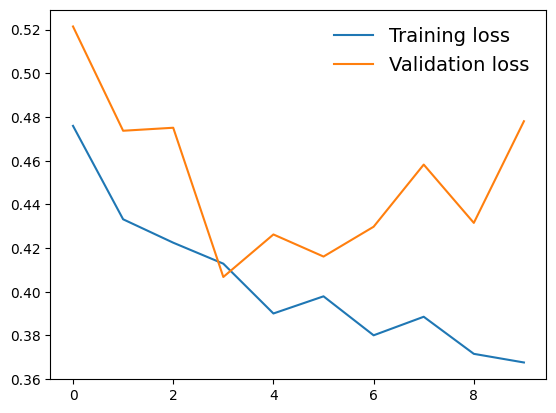

In [50]:
plt.plot(train_losses, label = "Training loss")
plt.plot(val_losses, label = "Validation loss")
plt.legend(frameon = False)

In [51]:
import glob

if len(glob.glob(f"{saving_path}/*.pth")) > 0:
    saved_model_params = glob.glob(f"{saving_path}/*.pth")[0]

loaded_model = nn.Sequential(nn.Flatten(),
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10))
loaded_model.load_state_dict(torch.load(saved_model_params))

<All keys matched successfully>

In [55]:
from bootcamp_libs.metrics.accuracy import check_accuracy

print("train accuracy: ", check_accuracy(train_dloader, loaded_model).item())
print("val accuracy: ", check_accuracy(val_dloader, loaded_model).item())
print("test accuracy: ", check_accuracy(test_dloader, loaded_model).item())

train accuracy:  0.8615599870681763
val accuracy:  0.853600025177002
test accuracy:  0.8410999774932861
